# Titanic Survivor Prediction

### As a beginner in Data Science,  I don't have much experience in Data Modeling and Model Optimization, what I can do better is to make sure data is as clean as possible, then use a simple algorithm. In this notebook, I am going to use multiple algorithms to predict the survival rate, then pick the best one.

### As the result: The Accuracy is 77%

### 1. Data collection

The datasets used are provided by Kaggle
- train.csv will be used to build the model
- test.csv will be used to generate the final result to be submitted

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
# Read input data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# A glance of the data - Train
df_train.head()

In [ ]:
# A glance of the data - test
df_test.head()

### 2. Data Cleaning

In this section, I will combine train and test sets to do data cleaning, following steps will be performed  
- Fill missing values
- Use categorised data instead of strings

In [3]:
# Concat train set and test test to do data cleaning
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
# Check null data
df_all.isnull().sum()

In [4]:
# Fill value for null data (except cabin)
df_all['Embarked'].fillna(df_all['Embarked'].mode()[0], inplace = True)
df_all['Fare'].fillna(df_all['Fare'].median(), inplace = True)
df_all['Age'].fillna(df_all['Age'].median(), inplace = True)
df_all['Survived'].fillna(9, inplace = True)

In [5]:
# convert object values to category using LabelEncoder()
label = LabelEncoder()
df_all['Sex_Code'] = label.fit_transform(df_all['Sex'])
df_all['Ticket_Code'] = label.fit_transform(df_all['Ticket'])
df_all['Embarked_Code'] = label.fit_transform(df_all['Embarked'])

In [6]:
# Add "Family Size" column = Siblings/Spouse + Parents/Children + Self
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

In [7]:
# Use Name column to determine title
df_all['Title'] = df_all['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
# Look for Title appears less than 10 times 
stat_min = 10
title_names = (df_all['Title'].value_counts() < stat_min)
df_all['Title'] = df_all['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [8]:
df_all['Title'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Misc       34
Name: Title, dtype: int64

In [9]:
df_all['Title_Code'] = label.fit_transform(df_all['Title'])

In [ ]:
# Check null data again
df_all.isnull().sum()

In [10]:
df_all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_Code,Ticket_Code,Embarked_Code,Family_Size,Title,Title_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,720,2,2,Mr,3
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,816,0,2,Mrs,4
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,914,2,1,Miss,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,65,2,2,Mrs,4
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,649,2,1,Mr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,9.0,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.0500,NaN,S,1,711,2,1,Mr,3
1305,1306,9.0,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0,834,0,1,Misc,1
1306,1307,9.0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,872,2,1,Mr,3
1307,1308,9.0,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.0500,NaN,S,1,579,2,1,Mr,3


### 3. Data Visualization

This step will give a better understanding of the data


In [11]:
# Get back our original train set
df_train = df_all.loc[df_all['Survived'].isin([0,1])]

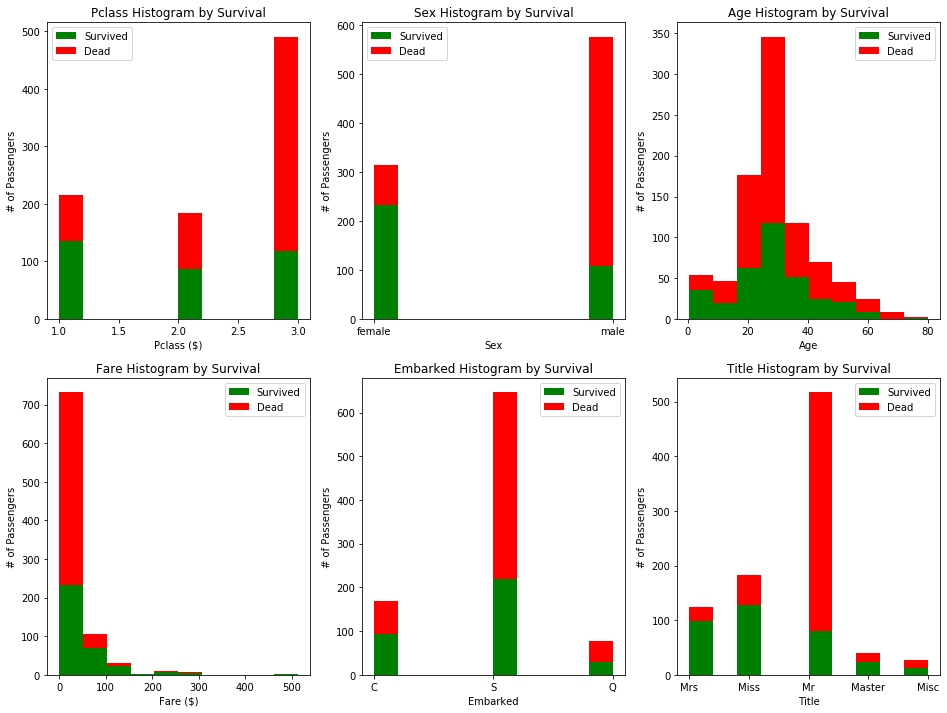

In [12]:
plt.figure(figsize=[16,12])

# Pclass
plt.subplot(231)
plt.hist(x = [df_train[df_train['Survived']==1]['Pclass'], df_train[df_train['Survived']==0]['Pclass']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Pclass Histogram by Survival')
plt.xlabel('Pclass ($)')
plt.ylabel('# of Passengers')
plt.legend()

# Sex
plt.subplot(232)
plt.hist(x = [df_train[df_train['Survived']==1]['Sex'], df_train[df_train['Survived']==0]['Sex']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Sex Histogram by Survival')
plt.xlabel('Sex')
plt.ylabel('# of Passengers')
plt.legend()

# Age
plt.subplot(233)
plt.hist(x = [df_train[df_train['Survived']==1]['Age'], df_train[df_train['Survived']==0]['Age']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age')
plt.ylabel('# of Passengers')
plt.legend()

# Fare
plt.subplot(234)
plt.hist(x = [df_train[df_train['Survived']==1]['Fare'], df_train[df_train['Survived']==0]['Fare']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

# Embarked
plt.subplot(235)
plt.hist(x = [df_train[df_train['Survived']==1]['Embarked'], df_train[df_train['Survived']==0]['Embarked']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Embarked Histogram by Survival')
plt.xlabel('Embarked')
plt.ylabel('# of Passengers')
plt.legend()

# Title
plt.subplot(236)
plt.hist(x = [df_train[df_train['Survived']==1]['Title'], df_train[df_train['Survived']==0]['Title']], 
         stacked=True, 
         color = ['g','r'],
         label = ['Survived','Dead'])
plt.title('Title Histogram by Survival')
plt.xlabel('Title')
plt.ylabel('# of Passengers')
plt.legend()

plt.show()

### 4. Data Preparation

- Split Train, Test
- Scale the data

In [13]:
# Features (columns) will be used
X_columns = ['Pclass', 'Sex_Code', 'Age', 'Family_Size', 'Fare', 'Ticket_Code', 'Embarked_Code', 'Title_Code']

# Convert to Array
X = df_train[X_columns].values
Y = df_train['Survived'].values

In [14]:
# Scale the data
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X.astype(float))
X 

array([[ 0.82737724,  0.73769513, -0.56573646, ...,  0.93143334,
         0.58595414,  0.2893919 ],
       [-1.56610693, -1.35557354,  0.66386103, ...,  1.27816704,
        -1.9423032 ,  1.40561778],
       [ 0.82737724, -1.35557354, -0.25833709, ...,  1.63212435,
         0.58595414, -0.82683399],
       ...,
       [ 0.82737724, -1.35557354, -0.1046374 , ...,  1.66463064,
         0.58595414, -0.82683399],
       [-1.56610693,  0.73769513, -0.25833709, ..., -1.62933949,
        -1.9423032 ,  0.2893919 ],
       [ 0.82737724,  0.73769513,  0.20276197, ...,  0.64971221,
        -0.67817453,  0.2893919 ]])

In [15]:
# Split into Train and Cross Validation
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (712, 8) (712,)
Test set: (179, 8) (179,)


### 5. Data Modeling

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [21]:
knn = KNeighborsClassifier()
knn.fit(X_train,Y_train)
preds = knn.predict(X_test)
knn_accuracy = accuracy_score(Y_test, preds)
print(f'KNN accuracy: {knn_accuracy*100}')

KNN accuracy: 79.3296089385475


In [22]:
lr = LogisticRegression()
lr.fit(X_train,Y_train)
preds = lr.predict(X_test)
lr_accuracy = accuracy_score(Y_test,preds)
print(f'Logistic Regression accuracy: {lr_accuracy*100}')

Logistic Regression accuracy: 76.53631284916202


In [23]:
dt = DecisionTreeClassifier()
dt.fit(X_train,Y_train)
preds = dt.predict(X_test)
dt_accuracy = accuracy_score(Y_test, preds)
print(f'Decission Tree accuracy: {dt_accuracy*100}')

Decission Tree accuracy: 76.53631284916202


In [24]:
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
preds = rf.predict(X_test)
rf_accuracy = accuracy_score(Y_test, preds)
print(f'RandomForest accuracy: {rf_accuracy*100}')

RandomForest accuracy: 80.44692737430168


In [25]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,Y_train)
preds = gbc.predict(X_test)
gbc_accuracy = accuracy_score(Y_test, preds)
print(f'GradientBoostClassifier accuracy: {gbc_accuracy*100}')

GradientBoostClassifier accuracy: 79.3296089385475


In [26]:
svc = SVC()
svc.fit(X_train,Y_train)
preds = svc.predict(X_test)
svc_accuracy = accuracy_score(Y_test, preds)
print(f'SVC accuracy: {svc_accuracy*100}')

SVC accuracy: 81.56424581005587


In [27]:
models = pd.DataFrame({'Model':['LogisticRegression','KNN','DecissionTree','RandomForest','GradientBoostClassifier','SVM'],
         'Accuracy':[lr_accuracy*100,knn_accuracy*100,dt_accuracy*100,rf_accuracy*100,gbc_accuracy*100,svc_accuracy*100]})
models

,Model,Accuracy
0,LogisticRegression,76.536313
1,KNN,79.329609
2,DecissionTree,76.536313
3,RandomForest,80.446927
4,GradientBoostClassifier,79.329609
5,SVM,81.564246


### 6. Predict the real test set

In [32]:
# Get the original test set
df_test = df_all.loc[df_all['Survived'].isin([9])]
X_test_real = df_test[X_columns].values
# Scale the data using the same Scaler 
X_test_real = scaler.transform(X_test_real)
# Predict 
yhat=svc.predict(X_test_real)
yhat.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [33]:
df_result = pd.DataFrame({'PassengerId':  df_test['PassengerId'], 'Survived': yhat.astype(int)})
df_result

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,0
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0


In [35]:
df_result.to_csv('my_submission_v1.3.csv', index=False)

### 7. Some words
This is a very basic machine learning practise, I know I still have a lot to learn and I open to all questions and advices. Thanks.